[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/var/folders/wf/wkc5gyjx51q3fnyhnvhx61q40000gn/T/ipykernel_3368/1299904570.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # 使用向后填充以处理缺失值


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0173
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.7870e-04
Epoch 16/50

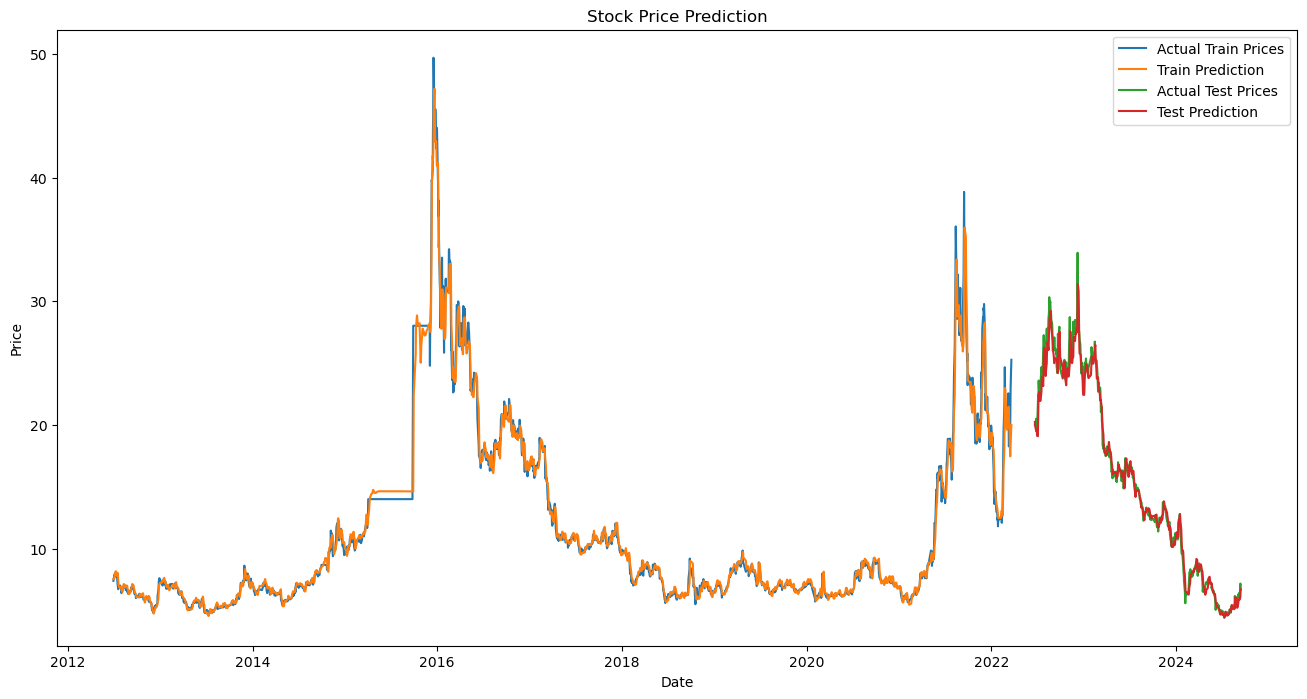

回测结果已导出到文件：backtest_results.xlsx


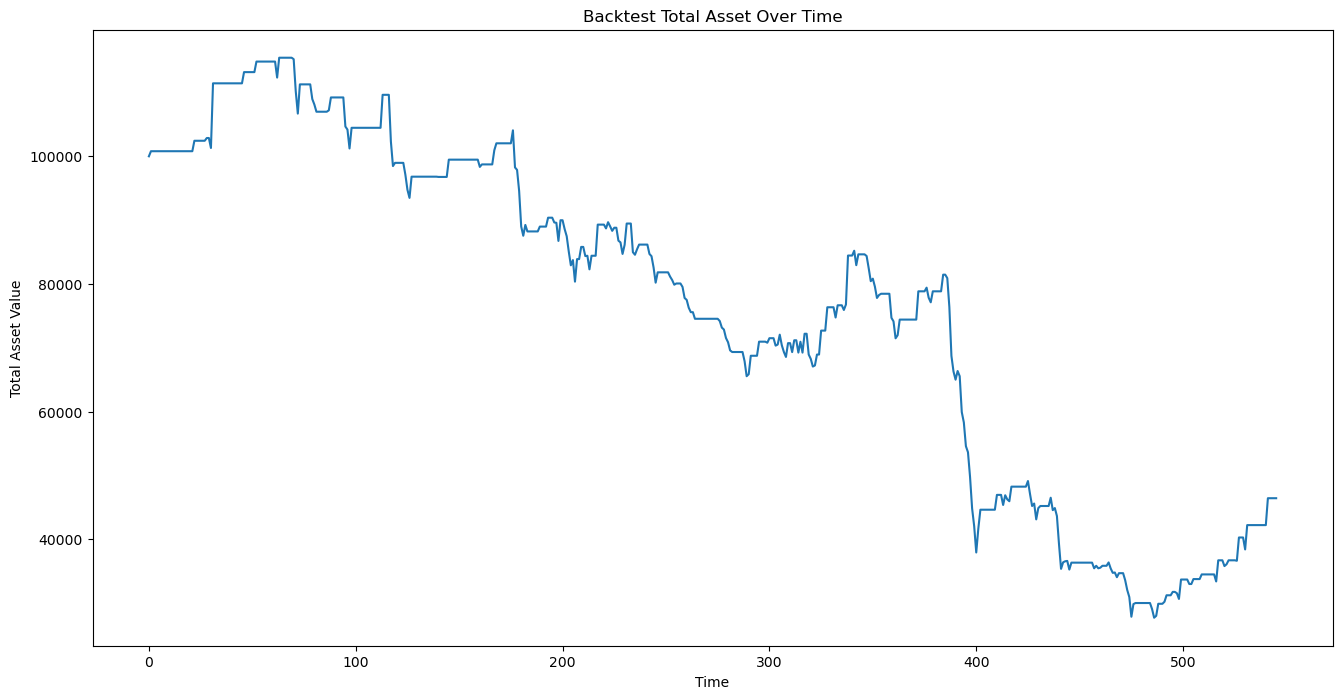

总收益：-53579.62 元
收益率：-53.58%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
import yfinance as yf
import datetime

# 获取股票数据
def get_stock_data(stock_symbol, start_date, end_date):
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    if df.empty:
        print(f"未能下载股票代码为 {stock_symbol} 的数据，请检查股票代码是否正确。")
        exit()
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return df

# 计算技术指标
def add_technical_indicators(df):
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.fillna(method='bfill', inplace=True)  # 使用向后填充以处理缺失值
    return df

# 获取并处理数据
stock_symbol = '002667.SZ'  # 威领股份（深A股）
start_date = '2010-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
df = get_stock_data(stock_symbol, start_date, end_date)
df = add_technical_indicators(df)

# 数据预处理
data = df[['Close', 'Volume', 'MA50', 'MA200', 'RSI']].values

# 检查数据中是否存在 NaN 值
if np.isnan(data).any():
    print("数据中存在 NaN 值，正在处理...")
    data = np.nan_to_num(data)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# LSTM模型
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

# 预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化预测结果
def invert_scale(predictions, scaler):
    extended = np.hstack((predictions, np.zeros((predictions.shape[0], data.shape[1] - 1))))
    return scaler.inverse_transform(extended)[:, 0]

train_predict = invert_scale(train_predict, scaler)
test_predict = invert_scale(test_predict, scaler)

# 实际价格
train_actual = invert_scale(y_train.reshape(-1, 1), scaler)
test_actual = invert_scale(y_test.reshape(-1, 1), scaler)

# 绘制训练和测试集的预测结果
plt.figure(figsize=(16, 8))
plt.plot(df['Date'][time_step:train_size], train_actual, label='Actual Train Prices')
plt.plot(df['Date'][time_step:train_size], train_predict, label='Train Prediction')
plt.plot(df['Date'][train_size+time_step:], test_actual, label='Actual Test Prices')
plt.plot(df['Date'][train_size+time_step:], test_predict, label='Test Prediction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.show()

# 买卖策略和回测
def backtest_strategy(predicted_prices, actual_prices, dates):
    signals = []
    positions = []
    cash = 100000  # 初始现金
    holdings = 0
    total_asset = cash
    flag = -1  # -1表示没有持仓，1表示持有多头
    last_buy_price = 0
    for i in range(len(predicted_prices)):
        date = dates[i]
        actual_price = actual_prices[i]
        predicted_price = predicted_prices[i]
        signal = np.nan
        profit = 0
        if predicted_price > actual_price:
            if flag != 1:
                signal = 'Buy'
                flag = 1
                last_buy_price = actual_price
                holdings = cash / actual_price
                cash = 0
                total_asset = holdings * actual_price
            else:
                signal = np.nan
                total_asset = holdings * actual_price
        elif predicted_price < actual_price:
            if flag != -1:
                signal = 'Sell'
                flag = -1
                cash = holdings * actual_price
                profit = cash - 100000  # 计算收益
                holdings = 0
                total_asset = cash
            else:
                signal = np.nan
                total_asset = cash
        else:
            signal = np.nan
            if flag == 1:
                total_asset = holdings * actual_price
            else:
                total_asset = cash
        positions.append({
            'Date': date,
            'Signal': signal,
            'Actual Price': actual_price,
            'Holdings': holdings,
            'Cash': cash,
            'Total Asset': total_asset,
            'Profit': profit if signal == 'Sell' else np.nan
        })
    return pd.DataFrame(positions)

# 获取测试集日期
test_dates = df['Date'][train_size+time_step:].reset_index(drop=True)

# 应用策略并进行回测
backtest_results = backtest_strategy(test_predict, test_actual, test_dates)

# 导出回测结果为 Excel 文件
output_filename = 'backtest_results.xlsx'
backtest_results.to_excel(output_filename, index=False)
print(f"回测结果已导出到文件：{output_filename}")

# 绘制资金曲线
backtest_results['Total Asset'].plot(figsize=(16,8))
plt.xlabel('Time')
plt.ylabel('Total Asset Value')
plt.title('Backtest Total Asset Over Time')
plt.show()

# 打印回测结果概览
total_profit = backtest_results['Total Asset'].iloc[-1] - 100000
print(f"总收益：{total_profit:.2f} 元")
print(f"收益率：{(total_profit / 100000) * 100:.2f}%")